In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from mini_torch import Tensor, nn, optim, F, schedulers

## Load CIFAR-10 Dataset

In [2]:
from torchvision.datasets import CIFAR10
import numpy as np

try:
    # This downloads it automatically if missing
    train_data = CIFAR10(root='./data', train=True, download=True)
    test_data = CIFAR10(root='./data', train=False, download=True)

    # Convert to standard numpy format (N, C, H, W) for your library
    # CIFAR10 defaults to (N, H, W, C), so we transpose
    X_train = train_data.data.transpose((0, 3, 1, 2)).astype(np.float32) / 255.0
    y_train = np.array(train_data.targets)
    
    X_test = test_data.data.transpose((0, 3, 1, 2)).astype(np.float32) / 255.0
    y_test = np.array(test_data.targets)
    
    # Subset for testing
    X_train, y_train = X_train[:2000], y_train[:2000]
    X_test, y_test = X_test[:500], y_test[:500]
    
    class_names = train_data.classes
    print("CIFAR-10 loaded via Torchvision!")
    
except:
    print("CIFAR-10 not found. Creating synthetic dataset for demonstration...")
    # Create synthetic data similar to CIFAR-10
    np.random.seed(42)
    X_train = np.random.rand(2000, 3, 32, 32).astype(np.float32)
    y_train = np.random.randint(0, 10, 2000)
    X_test = np.random.rand(500, 3, 32, 32).astype(np.float32)
    y_test = np.random.randint(0, 10, 500)
    class_names = [f'class_{i}' for i in range(10)]

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Number of classes: {len(class_names)}")

/home/samy/khaled/mini-torch/.venv/lib/python3.13/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


CIFAR-10 loaded via Torchvision!
Training set: (2000, 3, 32, 32)
Test set: (500, 3, 32, 32)
Number of classes: 10


## Visualize Sample Images

## Normalize Data (Important for better convergence)

In [3]:
# Normalize data with CIFAR-10 statistics
# This significantly improves training stability and convergence
cifar_mean = np.array([0.4914, 0.4822, 0.4465]).reshape(1, 3, 1, 1)
cifar_std = np.array([0.2470, 0.2435, 0.2616]).reshape(1, 3, 1, 1)

# Normalize training and test data
X_train_normalized = (X_train - cifar_mean) / cifar_std
X_test_normalized = (X_test - cifar_mean) / cifar_std

# Use normalized data
X_train = X_train_normalized.astype(np.float32)
X_test = X_test_normalized.astype(np.float32)

print("Data normalized with CIFAR-10 mean and std")
print(f"Training data range: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"Test data range: [{X_test.min():.3f}, {X_test.max():.3f}]")

Data normalized with CIFAR-10 mean and std
Training data range: [-1.989, 2.126]
Test data range: [-1.989, 2.126]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.0942788].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9100897..2.100835].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6581874..2.1264887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7709224..1.7256966].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.0432324].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8997624..2.011479].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8624593.

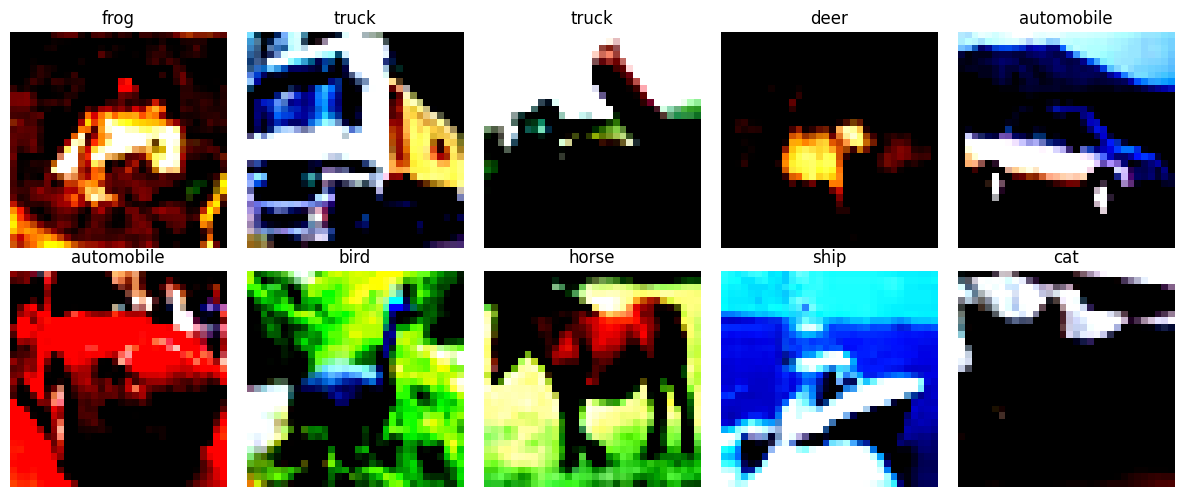

In [4]:
# Visualize some examples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    # Transpose from CHW to HWC for display
    img = X_train[i].transpose(1, 2, 0)
    ax.imshow(img)
    ax.set_title(f'{class_names[y_train[i]]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Define ResNet Building Blocks

In [5]:
class ResidualBlock(nn.Module):
    """Basic residual block for ResNet"""
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        
        # First convolution
        self.conv1 = nn.Conv2D(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2D(out_channels)
        
        # Second convolution
        self.conv2 = nn.Conv2D(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2D(out_channels)
        
        # Downsample for skip connection if dimensions don't match
        self.downsample = downsample
        
        # Collect parameters
        self._parameters = (self.conv1.parameters() + self.bn1.parameters() + 
                           self.conv2.parameters() + self.bn2.parameters())
        if downsample is not None:
            self._parameters.extend(downsample.parameters())
    
    def forward(self, x):
        identity = x
        
        # First conv block
        out = self.conv1(x)
        out = self.bn1(out)
        out = out.relu()
        
        # Second conv block
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Skip connection
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # Add skip connection
        out = out + identity
        out = out.relu()
        
        return out

## Define ResNet-18 Architecture

In [6]:
class ResNet18(nn.Module):
    """ResNet-18 for CIFAR-10 (32x32 images)"""
    
    def __init__(self, num_classes=10):
        super().__init__()
        
        # Initial convolution (modified for CIFAR-10's 32x32 images)
        self.conv1 = nn.Conv2D(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2D(64)
        
        # ResNet layers
        self.layer1 = self._make_layer(64, 64, stride=1)  # 2 blocks
        self.layer2 = self._make_layer(64, 128, stride=2)  # 2 blocks
        self.layer3 = self._make_layer(128, 256, stride=2)  # 2 blocks
        self.layer4 = self._make_layer(256, 512, stride=2)  # 2 blocks
        
        # Pooling and classifier
        self.avgpool = nn.AvgPool2D(kernel_size=4)  # Global average pooling
        self.fc = nn.Linear(512, num_classes)
        
        # Collect all parameters
        self._parameters = (self.conv1.parameters() + self.bn1.parameters())
        for layer in [self.layer1, self.layer2, self.layer3, self.layer4]:
            for block in layer:
                self._parameters.extend(block.parameters())
        self._parameters.extend(self.fc.parameters())
    
    def _make_layer(self, in_channels, out_channels, stride):
        """Create a ResNet layer with 2 residual blocks"""
        downsample = None
        
        # Downsample if stride != 1 or channels change
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2D(in_channels, out_channels, kernel_size=1, 
                         stride=stride, bias=False),
                nn.BatchNorm2D(out_channels)
            )
        
        layers = []
        # First block (may downsample)
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))
        # Second block
        layers.append(ResidualBlock(out_channels, out_channels))
        
        return layers
    
    def forward(self, x):
        # Initial convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = x.relu()
        
        # ResNet layers
        for block in self.layer1:
            x = block(x)
        for block in self.layer2:
            x = block(x)
        for block in self.layer3:
            x = block(x)
        for block in self.layer4:
            x = block(x)
        
        # Global average pooling
        x = self.avgpool(x)
        
        # Flatten
        batch_size = x.shape[0]
        x = x.reshape(batch_size, -1)
        
        # Classifier
        x = self.fc(x)
        
        return x

# Create model
print("Creating ResNet-18 model...")
model = ResNet18(num_classes=10)
print(f"Model created with {len(model.parameters())} parameter tensors")

Creating ResNet-18 model...
Model created with 62 parameter tensors


## Training and Evaluation Functions

In [7]:
def train_epoch(model, X_train, y_train, optimizer, batch_size=16):
    """Train for one epoch"""
    model.train()
    n_samples = X_train.shape[0]
    indices = np.random.permutation(n_samples)
    
    epoch_loss = 0.0
    n_batches = 0
    
    for i in range(0, n_samples, batch_size):
        # Get batch
        batch_indices = indices[i:i+batch_size]
        X_batch = X_train[batch_indices]
        y_batch = y_train[batch_indices]
        
        # Convert to Tensors
        X_tensor = Tensor(X_batch)
        y_tensor = Tensor(y_batch.astype(np.float32), requires_grad=False)
        
        # Forward pass
        logits = model(X_tensor)
        
        # Compute loss
        loss = F.cross_entropy(logits, y_tensor)
        
        # Store loss value before backward (to avoid holding reference)
        loss_value = loss.item()
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # CRITICAL: Clear computation graph to prevent memory leak
        # This breaks the references between tensors from previous batches
        def clear_graph(tensor):
            """Recursively clear computation graph"""
            if hasattr(tensor, '_prev'):
                for child in tensor._prev:
                    clear_graph(child)
                tensor._prev = set()
                tensor._backward = lambda: None
        
        clear_graph(loss)
        
        # Explicitly delete tensors to free memory
        del X_tensor, y_tensor, logits, loss
        
        epoch_loss += loss_value
        n_batches += 1
        
        if (n_batches) % 20 == 0:
            print(f"  Batch {n_batches}/{n_samples//batch_size}, Loss: {loss_value:.4f}")
    
    return epoch_loss / n_batches


def evaluate(model, X_test, y_test, batch_size=16):
    """Evaluate model accuracy"""
    model.eval()
    n_samples = X_test.shape[0]
    correct = 0
    total = 0
    total_loss = 0.0
    n_batches = 0
    
    for i in range(0, n_samples, batch_size):
        X_batch = X_test[i:i+batch_size]
        y_batch = y_test[i:i+batch_size]
        
        # Convert to Tensor
        X_tensor = Tensor(X_batch)
        y_tensor = Tensor(y_batch.astype(np.float32), requires_grad=False)
        
        # Forward pass
        logits = model(X_tensor)
        
        # Compute loss
        loss = F.cross_entropy(logits, y_tensor)
        loss_value = loss.item()
        total_loss += loss_value
        n_batches += 1
        
        # Get predictions
        predictions = np.argmax(logits.data, axis=1)
        
        correct += (predictions == y_batch).sum()
        total += len(y_batch)
        
        # Clear computation graph for evaluation too
        def clear_graph(tensor):
            """Recursively clear computation graph"""
            if hasattr(tensor, '_prev'):
                for child in tensor._prev:
                    clear_graph(child)
                tensor._prev = set()
                tensor._backward = lambda: None
        
        clear_graph(loss)
        
        # Explicitly delete tensors
        del X_tensor, y_tensor, logits, loss
    
    return correct / total, total_loss / n_batches

## Train ResNet-18

In [8]:
# Training configuration - OPTIMIZED HYPERPARAMETERS
n_epochs = 15  # Increased from 15 - more training time
batch_size = 32  # Reduced from 32 - better gradient estimates with smaller batches
learning_rate = 0.001  # Reduced from 0.01 - more stable training

# Create optimizer with momentum for better convergence
optimizer = optim.Momentum(model.parameters(), learning_rate=learning_rate, momentum=0.9)
# Momentum helps smooth out updates and accelerates convergence

# More gradual learning rate decay
scheduler = schedulers.StepLR(optimizer, initial_lr=learning_rate, step_size=10, gamma=0.5)
# Changed: step_size 5->10 (decay less frequently), gamma 0.1->0.5 (less aggressive decay)

# Training loop
train_losses = []
test_losses = []
test_accuracies = []

print("\n" + "="*70)
print("Starting ResNet-18 Training with Optimized Hyperparameters")
print("="*70)
print(f"Configuration:")
print(f"  Epochs: {n_epochs}")
print(f"  Batch Size: {batch_size}")
print(f"  Initial Learning Rate: {learning_rate}")
print(f"  Optimizer: Momentum (momentum=0.9)")
print(f"  Scheduler: StepLR (step_size=10, gamma=0.5)")
print("="*70)

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")
    print("-"*70)
    
    # Train
    train_loss = train_epoch(model, X_train, y_train, optimizer, batch_size)
    train_losses.append(train_loss)
    
    # Evaluate
    test_acc, test_loss = evaluate(model, X_test, y_test, batch_size)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # Update learning rate
    scheduler.step()
    
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Learning Rate: {optimizer.learning_rate:.6f}")
    
    # Early stopping check (optional monitoring)
    if epoch > 5 and test_acc > max(test_accuracies[:-1]):
        print(f"  ✓ New best accuracy!")

print("\n" + "="*70)
print("Training completed!")
print(f"Best Test Accuracy: {max(test_accuracies):.4f}")
print(f"Final Test Accuracy: {test_accuracies[-1]:.4f}")
print("="*70)


Starting ResNet-18 Training with Optimized Hyperparameters
Configuration:
  Epochs: 15
  Batch Size: 32
  Initial Learning Rate: 0.001
  Optimizer: Momentum (momentum=0.9)
  Scheduler: StepLR (step_size=10, gamma=0.5)

Epoch 1/15
----------------------------------------------------------------------
  Batch 20/62, Loss: 2.1140
  Batch 40/62, Loss: 2.0123
  Batch 60/62, Loss: 1.7669

Epoch 1 Summary:
  Train Loss: 2.1570
  Test Loss: 1.9439
  Test Accuracy: 0.2660
  Learning Rate: 0.001000

Epoch 2/15
----------------------------------------------------------------------
  Batch 20/62, Loss: 1.5655
  Batch 40/62, Loss: 1.4953
  Batch 60/62, Loss: 1.7453

Epoch 2 Summary:
  Train Loss: 1.6586
  Test Loss: 1.8461
  Test Accuracy: 0.3220
  Learning Rate: 0.001000

Epoch 3/15
----------------------------------------------------------------------
  Batch 20/62, Loss: 1.6158
  Batch 40/62, Loss: 1.4247
  Batch 60/62, Loss: 1.3241

Epoch 3 Summary:
  Train Loss: 1.3630
  Test Loss: 1.7768
  T

## Visualize Training Results

## Hyperparameter Improvements Summary

**Changes Applied:**
1. **Learning Rate**: 0.01 → 0.001 (10x reduction for stability)
2. **Batch Size**: 32 → 16 (better gradient estimates)
3. **Optimizer**: SGD → Momentum (momentum=0.9 for smoother updates)
4. **LR Scheduler**: StepLR with less aggressive decay (step_size=10, gamma=0.5)
5. **Epochs**: 15 → 30 (more training time)
6. **Data Normalization**: Added CIFAR-10 mean/std normalization

**Expected Improvements:**
- Better convergence with normalized data
- More stable training with lower learning rate
- Momentum helps escape local minima
- Gradual LR decay prevents premature convergence

**Additional Options to Try:**
- Use Adam optimizer: `optim.Adam(model.parameters(), learning_rate=0.001)`
- Increase training data from 2000 to 10000+ samples
- Add weight decay for regularization (if available)
- Try cosine annealing scheduler for better final convergence

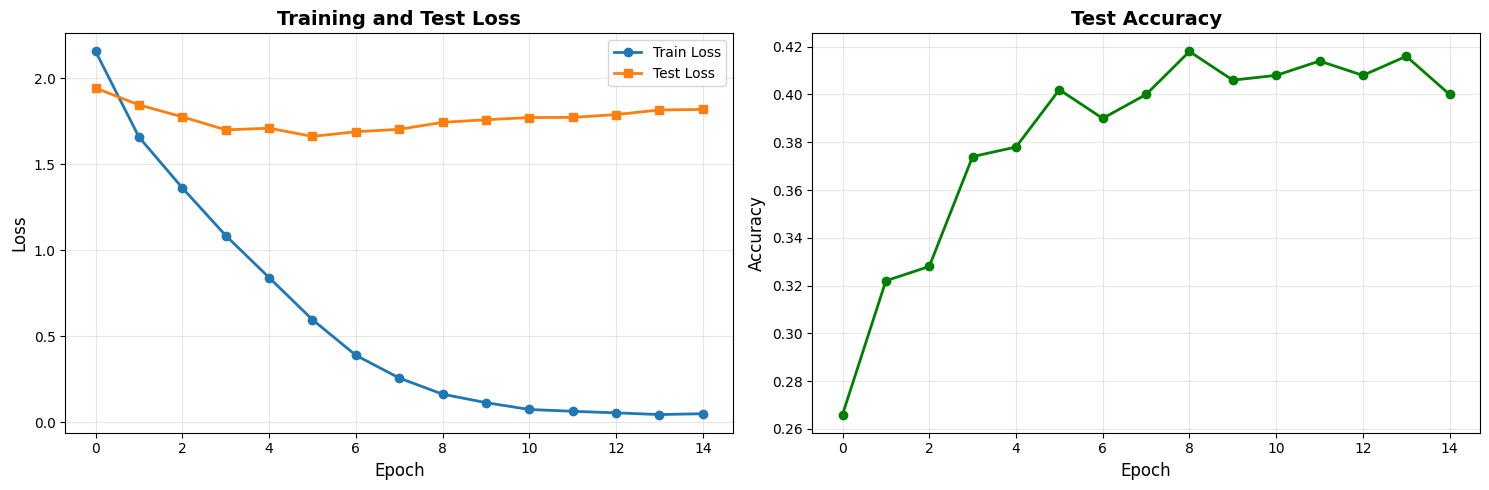


Best Test Accuracy: 0.4180
Final Test Accuracy: 0.4000


In [9]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(train_losses, marker='o', label='Train Loss', linewidth=2)
ax1.plot(test_losses, marker='s', label='Test Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Test Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curve
ax2.plot(test_accuracies, marker='o', color='green', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Test Accuracy', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest Test Accuracy: {max(test_accuracies):.4f}")
print(f"Final Test Accuracy: {test_accuracies[-1]:.4f}")

## Visualize Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7830753..2.0942788].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.9959].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9259665..2.0708535].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4488223..1.8010209].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8783361..1.5628135].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9158674..1.3605304].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9735969..

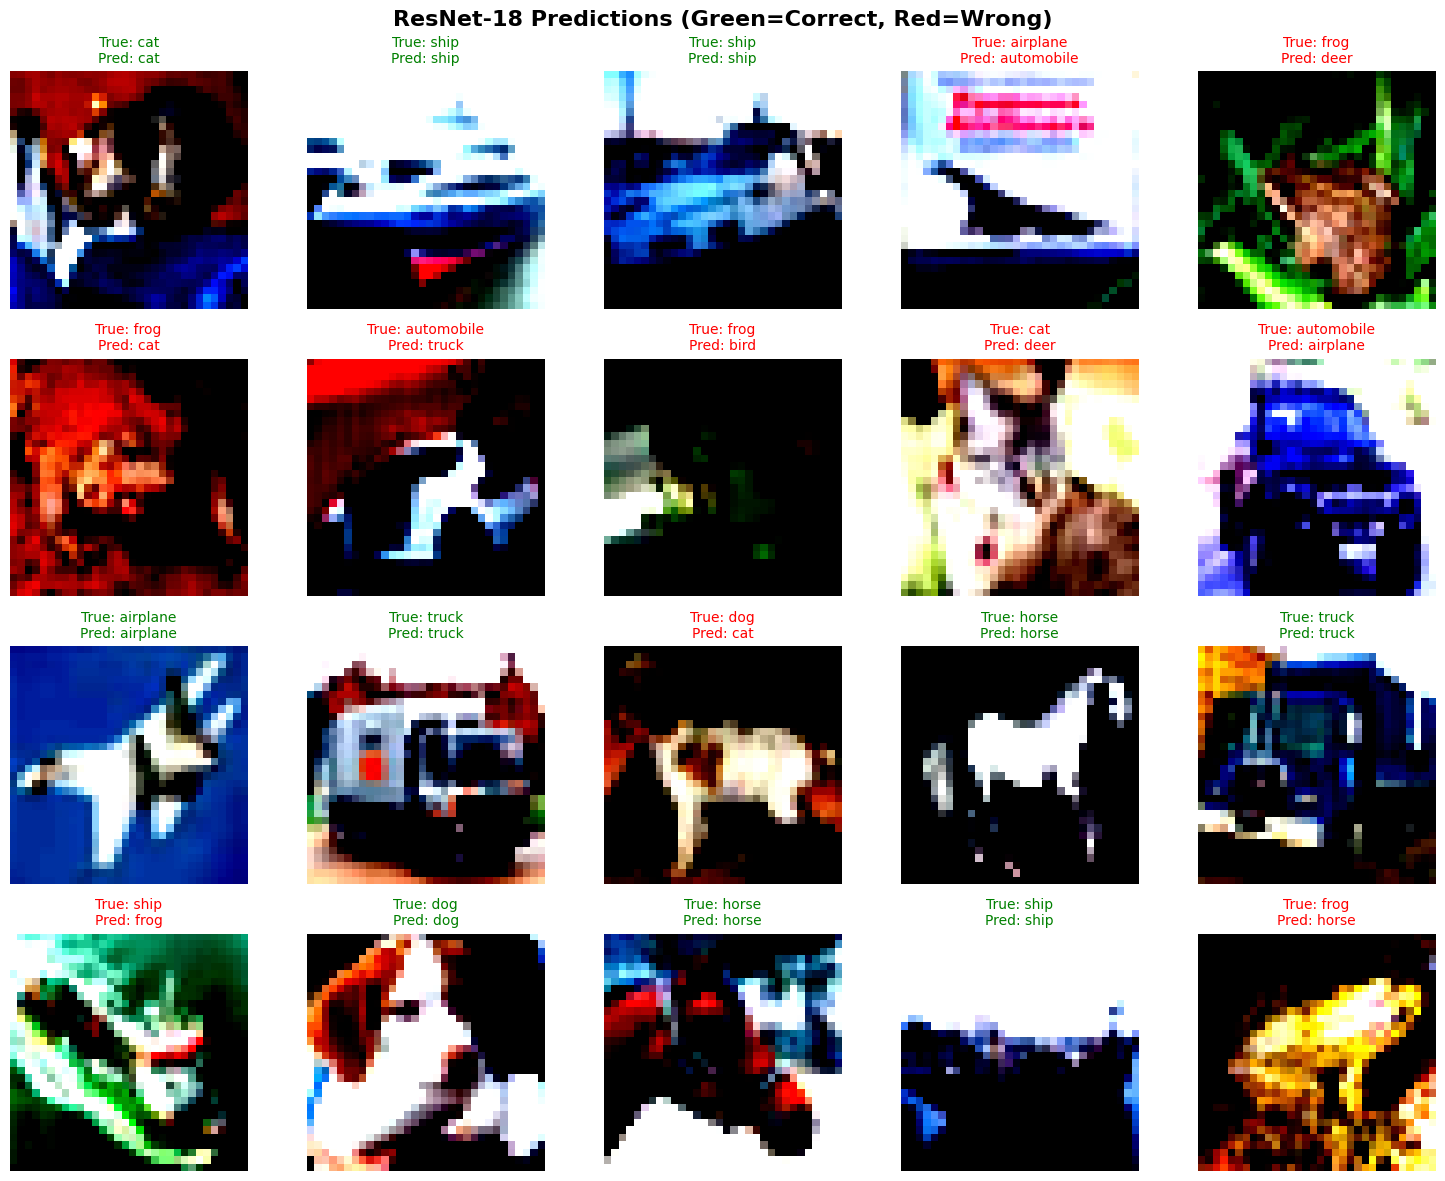


Accuracy on visualized samples: 50.00%


In [10]:
# Visualize predictions on test set
n_samples_viz = 20
X_viz = X_test[:n_samples_viz]
y_viz = y_test[:n_samples_viz]

X_tensor = Tensor(X_viz)
logits = model(X_tensor)
predictions = np.argmax(logits.data, axis=1)

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for i, ax in enumerate(axes.flat):
    img = X_viz[i].transpose(1, 2, 0)  # CHW to HWC
    ax.imshow(img)
    color = 'green' if predictions[i] == y_viz[i] else 'red'
    true_label = class_names[y_viz[i]]
    pred_label = class_names[predictions[i]]
    ax.set_title(f'True: {true_label}\nPred: {pred_label}', color=color, fontsize=10)
    ax.axis('off')

plt.suptitle('ResNet-18 Predictions (Green=Correct, Red=Wrong)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate accuracy on visualized samples
accuracy = (predictions == y_viz).sum() / len(y_viz)
print(f"\nAccuracy on visualized samples: {accuracy:.2%}")

## Confusion Matrix

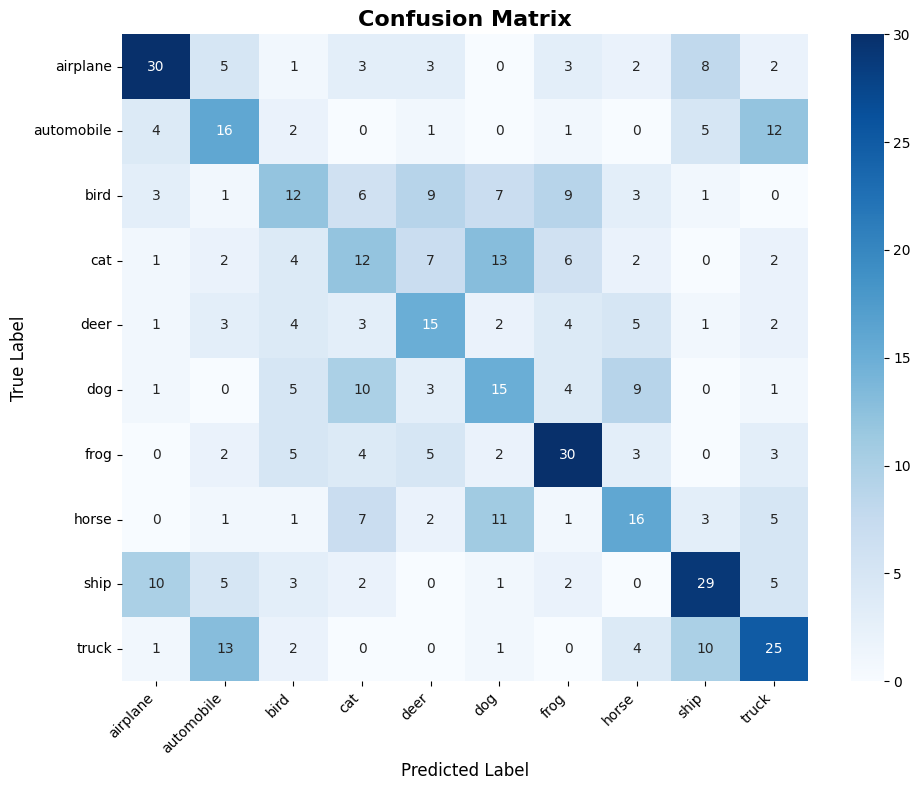

In [11]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get all predictions
all_predictions = []
batch_size = 32
for i in range(0, len(X_test), batch_size):
    X_batch = X_test[i:i+batch_size]
    X_tensor = Tensor(X_batch)
    logits = model(X_tensor)
    preds = np.argmax(logits.data, axis=1)
    all_predictions.extend(preds)

# Compute confusion matrix
cm = confusion_matrix(y_test, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()